# Beta Bank

Beta Bank customers are leaving: little by little, chipping away every month.<br>
The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.<br><br>
<b>Our tasks are: </b><br>
 We need to predict whether a customer will leave the bank soon.<br>
 You have the data on clients’ past behavior and termination of contracts with the bank.<br>
Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.
Additionally, measure the AUC-ROC metric and compare it with the F1.

Features
- RowNumber — data string index
-  CustomerId — unique customer identifier
-  Surname — surname
-  CreditScore — credit score
-  Geography — country of residence
-  Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary <br><br>
Target
- Exited — сustomer has left

## Download and prepare the data

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, roc_curve,roc_auc_score
from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import pprint

In [14]:
# const random_state 
RANDOM_STATE = 12345

In [15]:
#Read csv file
bank_customers = pd.read_csv('/datasets/Churn.csv') 
#General information
bank_customers.info()
bank_customers.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6932,6933,15570970,Han,647,France,Female,42,9.0,0.00,2,1,1,51362.82,0
8368,8369,15637690,Houghton,622,Germany,Female,34,7.0,98675.74,1,1,0,138906.85,1
6575,6576,15651883,Genovesi,794,Germany,Female,55,6.0,115796.70,1,1,0,160526.36,1
6948,6949,15803750,Ball,750,Spain,Female,33,3.0,161801.47,1,0,1,153288.97,1
2296,2297,15582714,Napolitani,749,Germany,Male,47,9.0,110022.74,1,0,1,135655.29,1
575,576,15653620,Gordon,546,France,Female,27,8.0,0.00,2,1,1,14858.10,0
6979,6980,15751180,Adams,539,France,Female,40,7.0,81132.21,1,1,0,167289.82,0
8220,8221,15727177,Manfrin,557,France,Male,42,6.0,177822.03,1,1,0,150944.31,1
9485,9486,15656319,Toscano,850,Spain,Male,37,NaN,88141.10,1,1,0,109659.12,0
2830,2831,15701555,Nicholls,575,Spain,Male,53,1.0,84903.33,2,0,1,26015.80,0


In [16]:
bank_customers['Tenure'].mean()

4.997690023099769

In [17]:
bank_customers[bank_customers['Tenure'].isnull()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [18]:
# fill missing values in 'Tenure' with mean value
#bank_customers['Tenure'].fillna(bank_customers['Tenure'].mean(), inplace=True)

#Filling missing values with 0. It may be that the customer does'nt have a deposit
bank_customers['Tenure'].fillna(0, inplace=True)


# Drop features that not required
bank_customers.drop(['Surname','CustomerId','RowNumber'], axis=1, inplace=True)

In [19]:
# check range of values to evaluate if the feature can be boolean 
bank_customers.Gender.unique()
# Change type to boolean
bank_customers.Gender = bank_customers.Gender.astype(bool)


In [20]:
# check range of values to evaluate if the feature can be boolean 
bank_customers.HasCrCard.unique()
# Change type to boolean
bank_customers.HasCrCard = bank_customers.HasCrCard.astype(bool)


In [21]:
# check range of values to evaluate if the feature can be boolean 
bank_customers.IsActiveMember.unique()
# Change type to boolean
bank_customers.IsActiveMember = bank_customers.IsActiveMember.astype(bool)


In [22]:
# check range of values to evaluate if the feature can be boolean 
bank_customers.Exited.unique()
# Change type to boolean
bank_customers.Exited = bank_customers.Exited.astype(bool)


In [23]:
#Check the field to understand what type of it
bank_customers.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

'Geography' has 3 values, so it a categorical feature

In [24]:
bank_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null bool
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null bool
IsActiveMember     10000 non-null bool
EstimatedSalary    10000 non-null float64
Exited             10000 non-null bool
dtypes: bool(4), float64(3), int64(3), object(1)
memory usage: 586.1+ KB


In [25]:

# Encode the Categorical features 
Categorical_features = ['Gender','HasCrCard','IsActiveMember','Exited','Geography']
encoder = OrdinalEncoder()

bank_customers[Categorical_features] = pd.DataFrame(encoder.fit_transform(bank_customers[Categorical_features]), columns=Categorical_features)
# Split the data into two sets:
# training set (train)
# validation set (valid) 
target = bank_customers['Exited']
features = bank_customers.drop(['Exited'], axis=1)
# Split data into train and validation
# using stratify in order to retain the same proportion of classes in the train and valid sets
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE,stratify =target)

# Split data into train and test.
# using stratify in order to retain the same proportion of classes in the train and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=RANDOM_STATE,stratify =target_train)


In [15]:
print(target_train.value_counts())
print(target_valid.value_counts())
print(target_test.value_counts())

0.0    4777
1.0    1223
Name: Exited, dtype: int64
0.0    1593
1.0     407
Name: Exited, dtype: int64
0.0    1593
1.0     407
Name: Exited, dtype: int64


In [16]:
# Silence SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

# Standardize the numeric features
scaler = StandardScaler()

#numeric fields to scale
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


In [17]:
#explorer the data
features_train.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1552,1.343580,0.0,0.0,-0.468981,-1.134997,-1.220573,-0.916018,1.0,1.0,-0.615290
7865,0.424586,2.0,0.0,-0.849532,1.435292,-1.220573,0.797767,0.0,1.0,-1.550885
1595,0.280025,0.0,0.0,-0.088430,-0.171138,-1.220573,0.797767,1.0,0.0,1.522022
3321,0.331654,0.0,0.0,-0.849532,1.435292,-1.220573,0.797767,1.0,1.0,-1.705708
609,0.496866,1.0,0.0,1.148359,-0.813711,0.555849,-0.916018,1.0,0.0,-0.239839
832,0.847943,1.0,0.0,-0.944670,-1.134997,1.248933,-0.916018,1.0,1.0,0.665804
8163,1.219671,1.0,0.0,0.862946,-1.456283,0.744863,-0.916018,1.0,1.0,-1.315065
7982,-1.082978,1.0,0.0,-0.564119,-1.134997,0.900015,0.797767,0.0,1.0,0.125416
775,-0.019423,0.0,0.0,-0.564119,0.792720,0.938675,-0.916018,1.0,1.0,0.292351
4120,0.166441,1.0,0.0,-1.705771,-1.134997,0.728796,0.797767,1.0,1.0,-0.006847


## Examine the balance of classes.  <br>    Train the model without taking into account the imbalance. 

In [18]:
class_count = bank_customers['Exited'].value_counts()
class_count

0.0    7963
1.0    2037
Name: Exited, dtype: int64

In [19]:
class_frequency = bank_customers['Exited'].value_counts(normalize=True)
print(class_frequency)

0.0    0.7963
1.0    0.2037
Name: Exited, dtype: float64


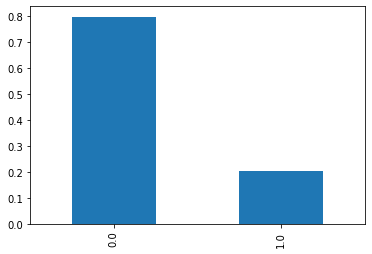

In [20]:
# plot a graph of frequency
class_frequency.plot(kind='bar');


In [21]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(features_train,target_train)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid)

print('Accuracy:', accuracy_valid )

Accuracy: 0.777


In [22]:
tn, fp, fn, tp = confusion_matrix(target_valid,predicted_valid).ravel()
print('TN = {} \nTP = {} \nFN = {} \nFP = {}'.format(tn, tp, fn, fp))

TN = 1350 
TP = 204 
FN = 203 
FP = 243


In [23]:
recall_score(target_valid,predicted_valid)

0.5012285012285013

We want the recall value to be close to 1. <br>
The value we got is 0.466  <br>
The model needs to be checked and fixed.

In [24]:
precision_score(target_valid,predicted_valid)

0.4563758389261745

We want the precision value to be close to 1. <br>
The value we got is 0.473   <br>
The model needs to be checked and fixed.

In [25]:
f1_score(target_valid,predicted_valid)

0.47775175644028106

We want the f1_score value to be close to 1. <br>
The value we got is 0.469   <br>
The model needs to be checked and fixed.

In [26]:
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid,probabilities_one_valid)


0.6743430641735726

In [42]:
# RandomForest model

# Create dictionary
result_dict={}
#TODO to 51
for estimator in range(1,51,1):
    for depth in range(1,11,1):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        key = 'n_estimators={},max_depth={} '.format(estimator,depth)
        result_dict[key] =  accuracy_score(target_valid,predicted_valid)
  

# Sort the dictionary by values       
sorted_results = sorted(result_dict.items(),key = lambda kv:(kv[1], kv[0]),reverse=True)

# Print the results in ascending order
pprint.pprint(sorted_results)




[('n_estimators=12,max_depth=9 ', 0.863),
 ('n_estimators=4,max_depth=9 ', 0.8625),
 ('n_estimators=23,max_depth=9 ', 0.8625),
 ('n_estimators=9,max_depth=9 ', 0.862),
 ('n_estimators=6,max_depth=9 ', 0.862),
 ('n_estimators=25,max_depth=9 ', 0.862),
 ('n_estimators=21,max_depth=9 ', 0.862),
 ('n_estimators=20,max_depth=9 ', 0.862),
 ('n_estimators=19,max_depth=9 ', 0.862),
 ('n_estimators=5,max_depth=9 ', 0.8615),
 ('n_estimators=26,max_depth=9 ', 0.8615),
 ('n_estimators=23,max_depth=10 ', 0.8615),
 ('n_estimators=17,max_depth=9 ', 0.8615),
 ('n_estimators=13,max_depth=9 ', 0.8615),
 ('n_estimators=10,max_depth=9 ', 0.8615),
 ('n_estimators=36,max_depth=9 ', 0.861),
 ('n_estimators=35,max_depth=9 ', 0.861),
 ('n_estimators=32,max_depth=9 ', 0.861),
 ('n_estimators=28,max_depth=9 ', 0.861),
 ('n_estimators=27,max_depth=9 ', 0.861),
 ('n_estimators=24,max_depth=9 ', 0.861),
 ('n_estimators=24,max_depth=10 ', 0.861),
 ('n_estimators=22,max_depth=9 ', 0.861),
 ('n_estimators=18,max_depth

We will chose n_estimators=12, max_depth=9 -> accuracy=0.863.<br>
its give the best result with minimum n_estimators and max_depth<br>

In [57]:
# RandomForest with the best hyper params 
model = RandomForestClassifier(n_estimators=12, max_depth=9, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('accuracy:{}'.format(accuracy_score(target_valid,predicted_valid)))
print('F1:{}'.format(f1_score(target_valid, predicted_valid)))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


accuracy:0.863
F1:0.5580645161290323
ROC_AUC:0.8603187162509195


In [58]:
#LogisticRegression model
model = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('accuracy:', accuracy_score(target_valid,predicted_valid ))
print('F1:', f1_score(target_valid, predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


accuracy: 0.808
F1: 0.2350597609561753
ROC_AUC:0.7511348019822596


### Conclusion

- We have imbalance classes: <br>
     class 0 with 7963 (0.7963 / 79.6% of the data) <br>
     class 1 with 2037(0.2037 / 20.3% of the data) <br>
- recall_score of the DecisionTree is 0.466 <br>
- precision_score of the DecisionTree is 0.4738 <br>
- DecisionTree
    - accuracy = 0.777 <br>
    - F1 = 0.477 <br>
    - ROC_AUC = 0.674
- RandomForest
    - n_estimators=12 , max_depth=9
    - accuracy = 0.863 <br>
    - F1 = 0.559 <br>
    - ROC_AUC = 0.860  <br>
- LogisticRegression    
    - accuracy: 0.808
    - F1: 0.235
    - ROC_AUC:0.751 <br>
<b>The modeles needs to be checked and fixed.</b>

##  Improve the quality of the model.

###  Class Weight Adjustment

In [59]:
# DecisionTreeClassifier model
model = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid)

print('f1_score:', f1_score(target_valid,predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


f1_score: 0.4724602203182375
ROC_AUC:0.6689902537360165


In [46]:
# RandomForest model

# Create dictionary
result_dict={}

for estimator in range(1,51,1):
    for depth in range(1,11,1):
        model = RandomForestClassifier(class_weight='balanced',n_estimators=estimator, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
                   
        # Calc f1 score and Add it to dictionary
        key = 'n_estimators={},max_depth={} '.format(estimator,depth)
        result_dict[key] =  f1_score(target_valid, predicted_valid)
        
            
print('The best F1 params')
# Sort the dictionary by values       
sorted_results = sorted(result_dict.items(),key = lambda kv:(kv[1], kv[0]),reverse=True)

# Print the results in ascending order
pprint.pprint(sorted_results)


The best F1 params
[('n_estimators=26,max_depth=9 ', 0.6352413019079686),
 ('n_estimators=49,max_depth=8 ', 0.634989200863931),
 ('n_estimators=48,max_depth=8 ', 0.6343042071197411),
 ('n_estimators=39,max_depth=8 ', 0.6343042071197411),
 ('n_estimators=28,max_depth=9 ', 0.6338185890257558),
 ('n_estimators=34,max_depth=8 ', 0.6337271750805586),
 ('n_estimators=28,max_depth=8 ', 0.6332622601279317),
 ('n_estimators=17,max_depth=8 ', 0.6331550802139037),
 ('n_estimators=27,max_depth=9 ', 0.632996632996633),
 ('n_estimators=47,max_depth=8 ', 0.6329386437029063),
 ('n_estimators=46,max_depth=8 ', 0.6329386437029063),
 ('n_estimators=38,max_depth=8 ', 0.632829373650108),
 ('n_estimators=50,max_depth=8 ', 0.6326086956521739),
 ('n_estimators=26,max_depth=8 ', 0.6324786324786326),
 ('n_estimators=16,max_depth=8 ', 0.632368703108253),
 ('n_estimators=15,max_depth=8 ', 0.6321467098166127),
 ('n_estimators=40,max_depth=8 ', 0.632034632034632),
 ('n_estimators=29,max_depth=8 ', 0.631914893617021

We will choose n_estimators=26,max_depth=9 it gives one of the best results.

In [69]:
model = RandomForestClassifier(class_weight='balanced',n_estimators=26, max_depth=9, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


F1: 0.6352413019079686
ROC_AUC:0.8569617383176706


In [48]:
# LogisticRegression model
model = LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE,solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


F1 score: 0.47364016736401676
ROC_AUC:0.7605031842319978


### Class Weight Adjustment conclusion

- using DecisionTree:
    - F1 score = 0.472
    - ROC_AUC = 0.668
- using LogisticRegression:
    - F1 score = 0.473
    - ROC_AUC = 0.760
- using RandomForest using n_estimators=26 and max_depth=9:
    - F1 score of 0.635
    - ROC_AUC = 0.856

### upsampling 

In [49]:
train_data = pd.concat([features_train, target_train], axis=1)
not_Exited = train_data[train_data.Exited==0]
Exited = train_data[train_data.Exited==1]

Exited_upsampled = resample(Exited,
                          replace=True, # sample with replacement
                          n_samples=len(not_Exited)- len(Exited), # match number in majority class
                          random_state=RANDOM_STATE) # reproducible results


# combine majority and upsampled minority
upsampled = pd.concat([not_Exited,Exited, Exited_upsampled])
upsampled = shuffle(upsampled, random_state=RANDOM_STATE)
print('Before upsampaling')
print(target_train.value_counts())

# check new class counts
print('After upsampaling')
print(upsampled.Exited.value_counts())


Before upsampaling
0.0    4777
1.0    1223
Name: Exited, dtype: int64
After upsampaling
1.0    4777
0.0    4777
Name: Exited, dtype: int64


In [50]:
target_train_upsampled = upsampled['Exited']
features_train_upsampled  = upsampled.drop(['Exited'], axis=1)

In [51]:
# DecisionTreeClassifier model
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(features_train_upsampled, target_train_upsampled)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid)

print('f1_score:', f1_score(target_valid,predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


f1_score: 0.4782608695652174
ROC_AUC:0.6732495207071477


In [52]:
# RandomForest model

# Create dictionary
result_dict={}

for estimator in range(1,51,1):
    for depth in range(1,11,1):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid)
       
        # Calc f1 score and Add it to dictionary
        key = 'n_estimators={},max_depth={} '.format(estimator,depth)
        result_dict[key] =  f1_score(target_valid, predicted_valid)
        
        
print('The best F1 params')
# Sort the dictionary by values       
sorted_results = sorted(result_dict.items(),key = lambda kv:(kv[1], kv[0]),reverse=True)

# Print the results in ascending order
pprint.pprint(sorted_results)

The best F1 params
[('n_estimators=34,max_depth=9 ', 0.6239495798319327),
 ('n_estimators=55,max_depth=10 ', 0.6215316315205328),
 ('n_estimators=39,max_depth=10 ', 0.6204620462046203),
 ('n_estimators=37,max_depth=9 ', 0.6200417536534446),
 ('n_estimators=56,max_depth=10 ', 0.6200000000000001),
 ('n_estimators=40,max_depth=10 ', 0.6196251378169791),
 ('n_estimators=28,max_depth=10 ', 0.6194111232279171),
 ('n_estimators=38,max_depth=10 ', 0.6192560175054704),
 ('n_estimators=54,max_depth=10 ', 0.6189427312775331),
 ('n_estimators=32,max_depth=9 ', 0.6185997910135841),
 ('n_estimators=57,max_depth=10 ', 0.6179401993355481),
 ('n_estimators=58,max_depth=10 ', 0.6175824175824176),
 ('n_estimators=29,max_depth=9 ', 0.6174636174636174),
 ('n_estimators=60,max_depth=10 ', 0.6174200661521501),
 ('n_estimators=52,max_depth=10 ', 0.6174200661521501),
 ('n_estimators=60,max_depth=9 ', 0.6171548117154811),
 ('n_estimators=25,max_depth=10 ', 0.6168831168831169),
 ('n_estimators=31,max_depth=9 ', 

In [65]:
# The chosen model
model = RandomForestClassifier(n_estimators=34, max_depth=9, random_state=RANDOM_STATE)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
       
print('F1:', f1_score(target_valid, predicted_valid))
# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


F1: 0.6239495798319327
ROC_AUC:0.8600040718684786


In [54]:
# LogisticRegression model
model = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))

# roc_auc calc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_valid,probabilities_one_valid)))


F1 score: 0.4815436241610738
ROC_AUC:0.7618728127202704


### Upsampling conclusion

- using DecisionTree:
    - F1 score of 0.478
    - ROC_AUC:0.673
- using LogisticRegression:
    - F1 score = 0.481
    - ROC_AUC=0.761
- using RandomForest using n_estimators=34 and max_depth=9:
    - F1 score = 0.623
    - ROC_AUC = 0.860

### Final Conclusion

RandomForest gave us the best results when we balanced the data
we will check which one of them will give us the best results using the test data

In [70]:
# RandomForest  using upsampling

model = RandomForestClassifier(n_estimators=34, max_depth=9, random_state=RANDOM_STATE)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_test = model.predict(features_test)
       
print('F1:', f1_score(target_test, predicted_test))
# roc_auc calc
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_test,probabilities_one_test)))


F1: 0.610655737704918
ROC_AUC:0.8621950147373876


In [71]:
#RandomForest  using class_weight='balanced'
model = RandomForestClassifier(class_weight='balanced',n_estimators=26, max_depth=9, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
       
print('F1:', f1_score(target_test, predicted_test))
# roc_auc calc
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('ROC_AUC:{}'.format(roc_auc_score(target_test,probabilities_one_test)))


F1: 0.620380739081747
ROC_AUC:0.8571445096868826


The best approach to balnce the data is using class_weight='balanced' on RandomForest model using n_estimators=26 and max_depth=9. <br>
f1 score = 0.620 <br>
ROC_AUC = 0.857  <br>

Before balancing the results were: <br>
F1 = 0.558 <br>
ROC_AUC = 0.860 <br> <br>

<b>We improved  the model</b>


## Perform the final testing.

In [61]:
# Create dictionary
result_dict={}
strategy_list=['stratified', 'most_frequent', 'prior', 'uniform','constant']


for strategy in strategy_list:  
    if strategy== 'constant':
         dummy_model = DummyClassifier(strategy=strategy, constant=1)
    else:
         dummy_model = DummyClassifier(strategy=strategy)
         
        
    dummy_model.fit(features_train, target_train)
    predicted_test = dummy_model.predict(features_test)

   # Add item to dictionary
    result_dict[strategy] =f1_score(target_test, predicted_test)
                 
# Sort the dictionary by values       
sorted_results = sorted(result_dict.items(),key = lambda kv:(kv[1], kv[0]),reverse=True)

# Print the results in ascending order
pprint.pprint(sorted_results)



[('constant', 0.3381803074366431),
 ('uniform', 0.2706552706552707),
 ('stratified', 0.2399020807833537),
 ('prior', 0.0),
 ('most_frequent', 0.0)]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


constant strategy  gave us the best F1 score 0.338

### Conclusion

The dummy model gave us F1 score of 0.338 .  <br>
The best approach to balnce the data is using RandomForest with class_weight='balanced' model using n_estimators=26 and max_depth=9. <br>
The f1 score that we got is 0.620   <br>
The roc_auc that we got is 0.860 <br>
<b> Our model is much better than the dummy model</b>